simpler data generator   
trainable vgg model  
train test dev split  
full dataset fetching  
weights for classes

In [1]:
# credits https://www.kaggle.com/kmader/train-simple-xray-cnn#ROC-Curves
import numpy as np 
import pandas as pd 
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
# unpack the images_???.zip into folders images_??? 

data_path = 'data'

all_xray_df = pd.read_csv(os.path.join(data_path, 'Data_Entry_2017.csv'))

images_paths = glob(os.path.join(data_path, 'images_???', 'images','*.png'))

all_image_paths = {os.path.basename(x): x for x in images_paths }

print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])

all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)

all_xray_df.sample(3)

Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
104038,00027758_007.png,Pleural_Thickening,7,27758,49,F,PA,2702,2991,0.143,0.143,NaN,data\images_011\images\00027758_007.png
102646,00027361_001.png,Atelectasis,1,27361,29,M,PA,2992,2991,0.143,0.143,NaN,data\images_011\images\00027361_001.png
13144,00003423_018.png,Mass,18,3423,60,M,PA,2992,2991,0.143,0.143,NaN,data\images_002\images\00003423_018.png


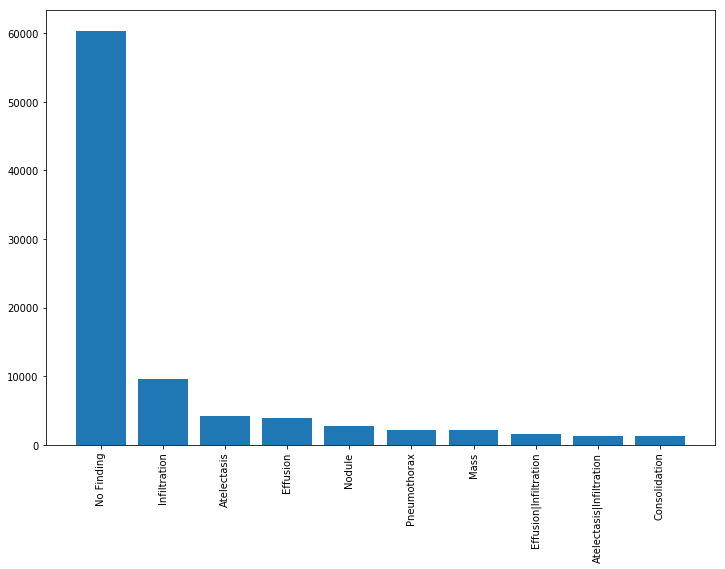

In [3]:
# only 10 top combinations of dicease
label_counts = all_xray_df['Finding Labels'].value_counts()[:10]
fig, ax1 = plt.subplots(1,1,figsize = (12, 8))
ax1.bar(np.arange(len(label_counts))+0.5, label_counts)
ax1.set_xticks(np.arange(len(label_counts))+0.5)
_ = ax1.set_xticklabels(label_counts.index, rotation = 90)

In [4]:
# all_xray_df['Finding Labels'] = all_xray_df['Finding Labels'].map(lambda x: x.replace('No Finding', ''))
all_xray_df['Finding Labels List'] = all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist()

In [5]:
all_labels = ['No Finding',
     'Atelectasis',
     'Cardiomegaly',
     'Effusion',
     'Infiltration',
     'Mass',
     'Pneumonia',
    'Pneumothorax',
        'Nodule']

In [6]:
all_xray_df.iloc[0,:]

Image Index                                           00000001_000.png
Finding Labels                                            Cardiomegaly
Follow-up #                                                          0
Patient ID                                                           1
Patient Age                                                         58
Patient Gender                                                       M
View Position                                                       PA
OriginalImage[Width                                               2682
Height]                                                           2749
OriginalImagePixelSpacing[x                                      0.143
y]                                                               0.143
Unnamed: 11                                                        NaN
path                           data\images_001\images\00000001_000.png
Finding Labels List                                     [Cardiomegaly]
Name: 

# data generator

In [7]:
from sklearn.model_selection import train_test_split

# all_xray_df_reset = all_xray_df.reset_index()

train_df, test_df = train_test_split(all_xray_df, 
                                   test_size = 0.25, 
                                   random_state = 1,
                                   stratify = all_xray_df['Finding Labels'].map(lambda x: x[:4]))
                                    # dirty hack for keeping values with approximately the same proportion

test_df, val_df = train_test_split(test_df, 
                                   test_size = 0.25, 
                                   random_state = 1,
                                   stratify = test_df['Finding Labels'].map(lambda x: x[:4]))

print('train', train_df.shape[0], 'test', test_df.shape[0], 'val', val_df.shape[0])

train 84090 test 21022 val 7008


In [8]:
from keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = (128, 128)
core_idg = ImageDataGenerator(samplewise_center=True, 
                              samplewise_std_normalization=True, 
                              horizontal_flip = True, 
                              vertical_flip = False, 
                              height_shift_range= 0.05, 
                              width_shift_range=0.1, 
                              rotation_range=5, 
                              shear_range = 0.1,
                              fill_mode = 'reflect',
                              zoom_range=0.15)

Using TensorFlow backend.


In [9]:
all_labels = ['No Finding',
     'Atelectasis',
     'Cardiomegaly',
     'Effusion',
     'Infiltration',
     'Mass',
     'Pneumonia',
    'Pneumothorax',
        'Nodule']

train_gen = core_idg.flow_from_dataframe(
    dataframe=train_df,
    directory=None,
    x_col='path',
    y_col='Finding Labels List',
    target_size=IMG_SIZE,
    color_mode='grayscale',
    class_mode="categorical",
    batch_size=256,
    classes=all_labels
)


val_gen = core_idg.flow_from_dataframe(
    dataframe=val_df,
    directory=None,
    x_col='path',
    y_col='Finding Labels List',
    target_size=IMG_SIZE,
    color_mode='grayscale',
    class_mode="categorical",
    batch_size=128,
    classes=all_labels
)


test_gen = core_idg.flow_from_dataframe(
    dataframe=test_df,
    directory=None,
    x_col='path',
    y_col='Finding Labels List',
    target_size=IMG_SIZE,
    color_mode='grayscale',
    class_mode="categorical",
    batch_size=128,
    classes=all_labels
)

Found 80286 images belonging to 9 classes.
Found 6686 images belonging to 9 classes.
Found 20038 images belonging to 9 classes.


In [10]:
a = next(train_gen)

In [11]:
train_gen.reset()

In [12]:
a[0].shape

(256, 128, 128, 1)

In [13]:
# make sure that encoding is right
print(a[1].sum(axis=1))
a[1]

[1. 2. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2. 1. 1. 1. 1. 1. 2. 1. 1. 1. 1. 1.
 3. 1. 1. 1. 1. 1. 2. 2. 1. 1. 1. 2. 1. 1. 1. 1. 1. 1. 1. 1. 2. 1. 1. 2.
 1. 2. 1. 1. 1. 3. 1. 1. 1. 1. 1. 2. 1. 1. 1. 1. 1. 1. 1. 2. 1. 1. 3. 1.
 1. 1. 1. 1. 2. 2. 1. 1. 1. 1. 1. 1. 1. 1. 1. 3. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 2. 1. 1. 1. 1. 2. 1. 2. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 3. 1. 1. 1. 1. 2. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2. 1. 2. 1. 2. 2. 2. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 3. 1. 2. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 5. 1. 2. 3. 1. 1. 1. 1. 1. 1. 1. 2. 1. 1. 2. 1. 1. 1. 1. 1.
 1. 1. 2. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2. 2. 1. 1. 1. 1. 3. 3. 1. 2.
 1. 3. 1. 1. 1. 1. 1. 1. 1. 2. 1. 2. 1. 2. 2. 1.]


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

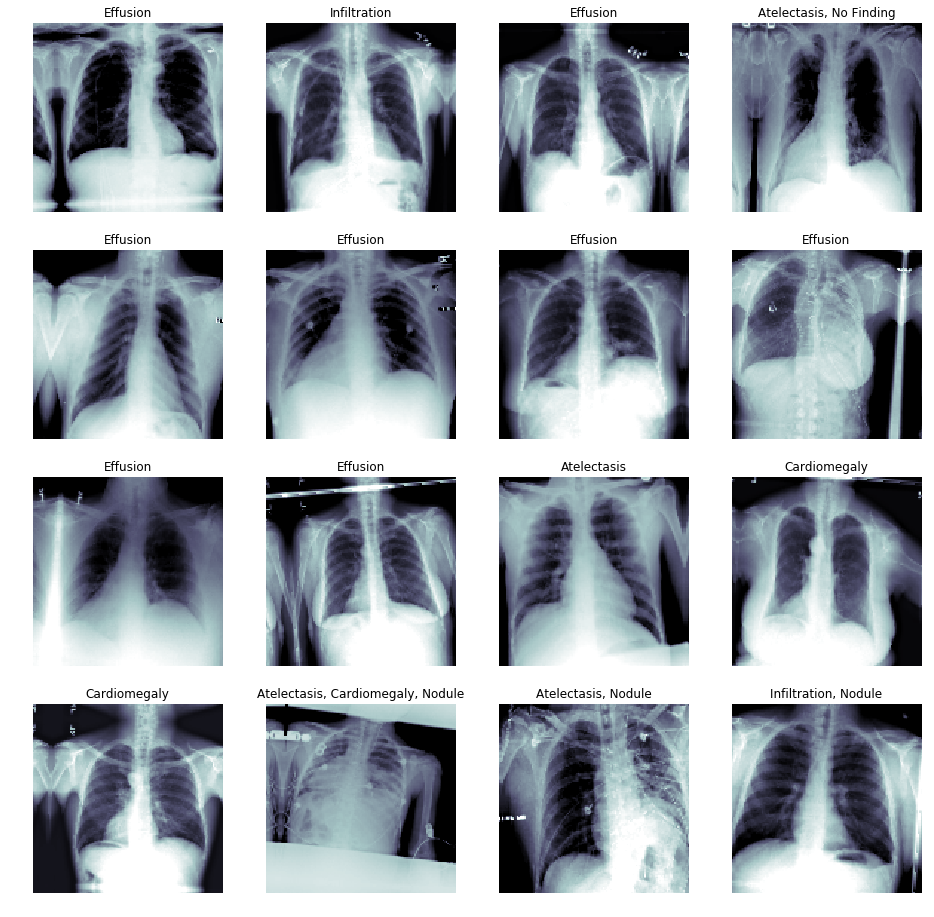

In [14]:
t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone', vmin = -1.5, vmax = 1.5)
    c_ax.set_title(', '.join([n_class for n_class, n_score in zip(train_gen.class_indices.keys(), c_y) 
                             if n_score>0.5]))
    c_ax.axis('off')


In [15]:
train_gen.reset()

In [16]:
total = all_xray_df.shape[0]

class_weights = {}

for key in train_gen.class_indices.keys():
    amount = all_xray_df['Finding Labels List'].map(lambda x: key in x).sum()
    class_number = train_gen.class_indices[key]
    class_weights [class_number] = total/amount

In [17]:
class_weights
# those will be passed to balance the model treating of different classes

{0: 9.699801020849554,
 1: 40.389048991354464,
 2: 8.419313659232559,
 3: 5.6358701115914345,
 4: 19.39121411276375,
 5: 1.8574907639038452,
 6: 17.709682514610645,
 7: 78.35080363382251,
 8: 21.146737080347037}

# model creation

In [18]:
t_x.shape[1:]

(128, 128, 1)

In [19]:

from keras.applications.vgg16 import VGG16

# from keras.applications.mobilenet import MobileNet
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Conv2D
from keras.models import Sequential


base_vgg16= VGG16(include_top = False, weights = 'imagenet')

In [20]:
multi_disease_model = Sequential()

In [21]:
'''
Freezed conv layer which produces the same image with 3 channels
'''
convol_same = Conv2D(trainable=False, input_shape=t_x.shape[1:], filters=3, kernel_size=(1, 1), strides=(1, 1), padding='valid', data_format=None, dilation_rate=(1, 1), activation=None, use_bias=True, kernel_initializer='ones', bias_initializer='zeros', kernel_regularizer=None, bias_regularizer=None, activity_regularizer=None, kernel_constraint=None, bias_constraint=None)

In [22]:
multi_disease_model.add(convol_same)

In [23]:
multi_disease_model.add(base_vgg16)
multi_disease_model.add(GlobalAveragePooling2D())
multi_disease_model.add(Dropout(0.5))
multi_disease_model.add(Dense(512))
multi_disease_model.add(Dropout(0.5))
multi_disease_model.add(Dense(len(all_labels), activation = 'sigmoid'))
multi_disease_model.compile(optimizer = 'adam', loss = 'binary_crossentropy',
                           metrics = ['binary_accuracy', 'mae'])
multi_disease_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 128, 128, 3)       6         
_________________________________________________________________
vgg16 (Model)                multiple                  14714688  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 512)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 9)                

In [24]:
with open('multi_disease_model_imagenet.json', 'w') as f:
    f.write(multi_disease_model.to_json())

In [25]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau, TensorBoard, Callback
import time

#weight_path="{}_weights.best.hdf5".format('xray_class')
weight_path='imagenet.{epoch:03d}-{val_loss:.3f}.hdf5'
checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)
#---------

early = EarlyStopping(monitor="val_loss",  mode="min", patience=5)

#---------

tb = TensorBoard(log_dir = 'tb')

#---------

class TimeHistory(Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, batch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)
        
time_callback = TimeHistory()

#---------

callbacks_list = [checkpoint, early, tb, time_callback]

In [26]:
multi_disease_model.fit_generator(train_gen, 
                                  steps_per_epoch=305,
                                  validation_data = val_gen, 
                                  validation_steps = 3,
                                  epochs = 30, 
                                  class_weight = class_weights,
                                  callbacks = callbacks_list)

Epoch 1/30
305/305 [==============================] - 1875s 6s/step - loss: 2.7979 - binary_accuracy: 0.8641 - mean_absolute_error: 0.2454 - val_loss: 0.3785 - val_binary_accuracy: 0.8634 - val_mean_absolute_error: 0.2323

Epoch 00001: val_loss improved from inf to 0.37851, saving model to imagenet.001-0.379.hdf5
Epoch 2/30
305/305 [==============================] - 1451s 5s/step - loss: 2.6842 - binary_accuracy: 0.8685 - mean_absolute_error: 0.2377 - val_loss: 0.3495 - val_binary_accuracy: 0.8678 - val_mean_absolute_error: 0.2170

Epoch 00002: val_loss improved from 0.37851 to 0.34948, saving model to imagenet.002-0.349.hdf5
Epoch 3/30
305/305 [==============================] - 1449s 5s/step - loss: 2.6264 - binary_accuracy: 0.8682 - mean_absolute_error: 0.2302 - val_loss: 0.3804 - val_binary_accuracy: 0.8652 - val_mean_absolute_error: 0.2367

Epoch 00003: val_loss did not improve from 0.34948
Epoch 4/30
305/305 [==============================] - 1438s 5s/step - loss: 2.6130 - binary_

KeyboardInterrupt: 

------------------------

In [27]:
from keras.models import model_from_json

# Model reconstruction from JSON file
with open('multi_disease_model_imagenet.json', 'r') as f:
    model = model_from_json(f.read())

# Load weights into the new model
model.load_weights('imagenet.006-0.336.hdf5')

In [28]:
def to_01(classes):
    size = len(classes)
    y = np.zeros((size, 9))
    for i in range(size):
        for j in classes[i]:
            y[i,j] = 1
    return y

test_y = to_01(test_gen.classes)

In [29]:
from tqdm import tqdm
test_gen.reset()
batch_size = 128
steps = len(test_gen.classes)//batch_size

test_y_list = []
pred_y_list = []

for i in tqdm(range(steps)):
    test_X, test_y = next(test_gen)
    pred_y = model.predict(test_X)
    
    test_y_list.append(test_y)
    pred_y_list.append(pred_y)
    
test_y_all = np.concatenate(test_y_list)
pred_y_all = np.concatenate(pred_y_list)

100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [09:03<00:00,  3.44s/it]


In [30]:
pred_y_all[:10]

array([[0.11294055, 0.14691804, 0.07969496, 0.17033407, 0.12104195,
        0.2174315 , 0.17359419, 0.06330631, 0.10791827],
       [0.09665647, 0.12032364, 0.05577699, 0.16316782, 0.11838466,
        0.254181  , 0.1828532 , 0.05881867, 0.08960665],
       [0.07710877, 0.09778658, 0.0453209 , 0.1631652 , 0.1218402 ,
        0.27326053, 0.19753441, 0.0532467 , 0.08469591],
       [0.06193965, 0.07147032, 0.02697675, 0.14867109, 0.12204469,
        0.33626133, 0.2219209 , 0.04810031, 0.05908305],
       [0.15703113, 0.20044225, 0.34976608, 0.26457453, 0.11518995,
        0.08192214, 0.10613827, 0.0736149 , 0.10768543],
       [0.13170557, 0.19318688, 0.15684284, 0.21316653, 0.11828314,
        0.14382719, 0.13884988, 0.07067341, 0.16282706],
       [0.20803457, 0.189241  , 0.4908314 , 0.28496805, 0.09957876,
        0.05575812, 0.07690315, 0.06290711, 0.08984547],
       [0.12438683, 0.13890606, 0.08015715, 0.16821903, 0.12316256,
        0.21489815, 0.17211254, 0.06467016, 0.09625425],


In [31]:
import pickle
pred_y_pickle = open("prediction.pkl", 'wb')

pickle.dump(pred_y_all, pred_y_pickle)
pred_y_pickle.close()

test_y_pickle = open("test_true.pkl", 'wb')
pickle.dump(test_y_all, test_y_pickle)

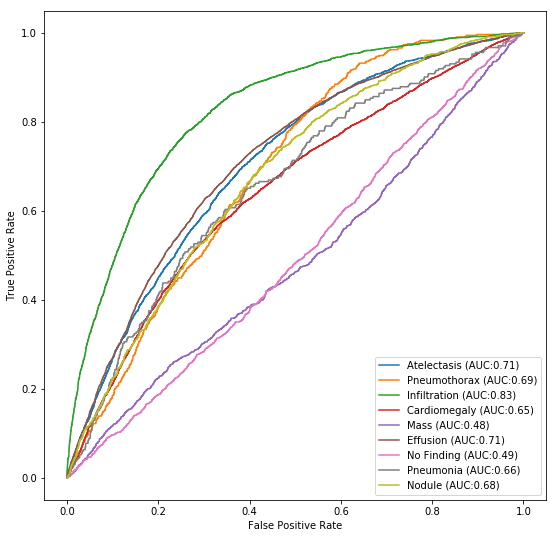

In [32]:
# building ROC curves

from sklearn.metrics import roc_curve, auc
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))

for (idx, c_label) in enumerate(train_gen.class_indices.keys()):
    fpr, tpr, thresholds = roc_curve(test_y_all[:,idx].astype(int), pred_y_all[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
fig.savefig('imagenet_trained_net.png')

-----

Coverage error represents the average amount of top positive labels we should predict to get all true ones. In ideal model it should be equal to the average amount of true labels.

In [33]:
from sklearn.metrics import coverage_error

print('coverage error', coverage_error(test_y_all, pred_y_all))

coverage error 3.1443810096153846


In [34]:
print('average amount of true labebls')
test_y_all.sum() / test_y_all.shape[0]

average amount of true labebls


1.1862479967948718

Hamming loss is the amount of wrongly predicted labels in average of the dataset.  
$$\frac{1}{|X|} \frac{1}{|L|}\sum_{i \; in \; samples} \sum_{j \; in \; labels}  1(f(x_{i})_{j} \not = y_{ij})$$  

Where $x_i$ is an input sample, $y_{ij}$ is a true label for the $j$ tag in sample $i$, $f$ is a prediction model, $|X| $ is amount of samlpes, $|L|$ is amount labels.

[0.5309773415242165, 0.31263911146723644, 0.19032118055555555, 0.12866141381766383, 0.12038706374643875, 0.12355324074074074, 0.1275318287037037, 0.1296630163817664, 0.13055889423076922, 0.1310096153846154, 0.1311821136039886, 0.13141025641025642, 0.13147702991452992, 0.1316161413817664, 0.1316550925925926, 0.13175525284900286, 0.1317886396011396, 0.13179420405982906, 0.13180533297720798, 0.13180533297720798]


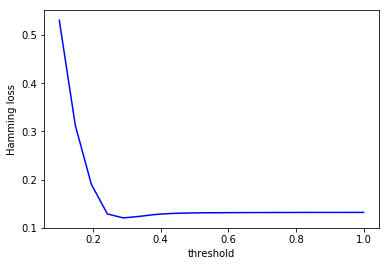

In [35]:
def plot_hamming_loss(pred_y, true_y):
    
    x = np.linspace(0.1, 1, 20)
    nr_of_classes = 9
    y = [((pred_y>i) != true_y).sum()/(nr_of_classes*len(pred_y)) for i in np.linspace(0.1, 1, 20)]
    print(y)
    
    plt.plot(x,y,'-b')
    plt.xlabel('threshold')
    plt.ylabel('Hamming loss')
    
plot_hamming_loss(pred_y_all, test_y_all)

Here we can see a dependency between the treshold and the Hamming loss. It drops at 0.25 and gaines a plateau with 0.13. 0.13 is the average amount of true labels in the dataset divided by 9. $1.18 / 9$ 

In [36]:
print('maximal values in predictions')

max_vals = pred_y_all.max(axis=1)
for d, val in zip(train_gen.class_indices.keys(), max_vals):
    print(d,' \t\t', val)


maximal values in predictions
Atelectasis  		 0.2174315
Pneumothorax  		 0.254181
Infiltration  		 0.27326053
Cardiomegaly  		 0.33626133
Mass  		 0.34976608
Effusion  		 0.21316653
No Finding  		 0.4908314
Pneumonia  		 0.21489815
Nodule  		 0.39760593


In [37]:
print('average values in predictions')

max_vals = pred_y_all.mean(axis=1)
for d, val in zip(train_gen.class_indices.keys(), max_vals):
    print(d,' \t\t', val)

average values in predictions
Atelectasis  		 0.13257554
Pneumothorax  		 0.126641
Infiltration  		 0.12377325
Cardiomegaly  		 0.121829785
Mass  		 0.16181831
Effusion  		 0.14770693
No Finding  		 0.17311862
Pneumonia  		 0.13141853
Nodule  		 0.12309272


-----